# Pulsar Signal Simulator Tutorial Notebook 1

This notebook will show you some of the basic features of the pulsar signal simulator, and will lead you through the steps of how to simulate your pulsar signal from start to finish.

The pulsar signal simulator can be run in a jupyter notebook or python script.

In [1]:
# import some useful packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import the pulsar signal simulator
import psrsigsim as pss

## The Signal

The first thing we need to do so simulate our pulsar is to initialize our signal. Once this is done, we'll come back to it later. This will be done for a filterbank-style signal class. This type of signal needs some values first though. It needs to how many frequency channels the signal should be recorded with, what the bandwidth of the signal is, what the center frequency of the signal is, and how quickly it should record the data, or the sampling rate. To make single pulses, we also need to set the 'fold' flag to False (the default is True).

For this example, we will simulate single pulses from a 350 MHz observation from the Green Bank Telescope.

In [2]:
# Define our signal variables.
f0 = 820 # center observing frequecy in MHz
bw = 200.0 # observation MHz
Nf = 128 # number of frequency channels
f_samp = 0.001526 # sample rate of data in MHz (here 0.6554 ms for size purposes)
# Now we define our signal
signal_1 = pss.signal.FilterBankSignal(fcent = f0, bandwidth = bw, Nsubband=Nf, fold = False)

## The Pulsar

Now we need to define our pulsar. Our pulsar needs a pulse shape though. There are a number of ways to define this in the pulsar signal simulator, but here we will make a simple, predefined Gaussian profile. The Guassian needs three parameters, an amplitude, a width (or sigma), and a peak, the center of the Gaussian in phase space (e.g. 0-1).

In [3]:
# We define the Guassian profile
gauss_prof = pss.pulsar.GaussProfile(peak = 0.5, width = 0.05, amp = 1.0)

Defining the profile just tells the simulator how to make the pulses. If we want to see what they look like, we need to initialize the profile, and then we can give it a number of phase bins and plot it.

In [4]:
# We want to use 2048 phase bins and just one frequency channel for this test.
gauss_prof.init_profiles(2048, Nchan = 1)

In [5]:
# We can look at the shape of the profile array to make sure it matches with what we expect
print(np.shape(gauss_prof.profiles))

(1, 2048)


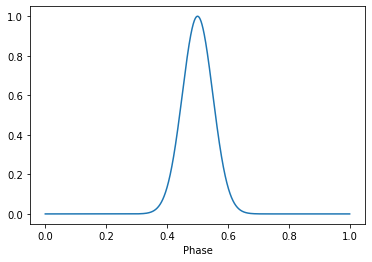

In [6]:
# And then we can plot the array to see what the profile looks like
plt.plot(np.linspace(0,1,2048), gauss_prof.profiles[0])
plt.xlabel("Phase")
plt.show()
plt.close()

Now we can define the pulsar object itself. Out pulsar needs a period (s), a mean flux (Jy), a profile, which we've defined above, and a name (e.g. JXXXX+XXXX). 

In [7]:
# Define the values needed for the puslar
period = 1.0 # pulse period of our simulated pulsar, here one second
Smean = 10.0 # The mean flux of the pulsar, here 10.0 Jy (note that this is very bright for a pulsar)
psr_name = "J0000+0000" # The name of our simulated pulsar
# Now we define the pulsar
pulsar_1 = pss.pulsar.Pulsar(period, Smean, profiles=gauss_prof, name = psr_name)

## The ISM

Now we define the interstellar medium (ISM) properties that will affect our pulsar signal as it 'travels' from the pulsar to our telescope. The main property here is the dispersion measure, DM, which is the number of electrons along the line of sight from us to the pulsar. These electrons will delay the pulsed emission from the pulsar, causing lower radio frequencies to arrive at the telescope later than higher radio frequencies. Here we will just define the ISM object and the DM we would like the pulsar to have.

In [8]:
# Define the dispersion measure
dm = 40.0 # pc cm^-3
# And define the ISM object, note that this class takes no initial arguements
ism_1 = pss.ism.ISM()

## The Telescope

The last thing we need to define is the telescope object. While you can define a telescope with any properties that you like with the pulsar signal simulator, it also comes with two pre-defined telescopes: The Arecibo Telescope and the Green Bank Telescope 9GBT). We will set up the GBT as our telescope. The telescope class when set up from a predefined telescope needs no additional input.

In [9]:
tscope = pss.telescope.telescope.GBT()

## Simulating the Signal

Now we have everything set up to actually simulate our signal, though there is one extra value we need to define: the simulated observation length (s). For size and time purposes, we will only simulate 2 seconds of observing, which amounts to just two pulse periods.

In [10]:
# define the observation length
obslen = 2.0 # seconds

Now we can make the pulses! This is done using the make_pulses() function of pulsar object we made before. It takes just the signal object, and the observation length.

In [11]:
pulsar_1.make_pulses(signal_1, tobs = obslen)

Now we want to disperse our pulses, or propagate them through the interstellar medium. We can do that easily using the disperse() function of the ISM object. This again takes the signal object, as well as the DM value defined above.

In [12]:
ism_1.disperse(signal_1, dm)

98% dispersed in 3.177 seconds.

Now we need to observe the signal with our telescope. This will add radiometer noise from the telescope receiver and backend to the signal. This is done using the observe() function of the telescope object, which takes the signal, the pulsar, the system name (for the GBT telescope this is either '820_GUPPI' or 'Lband_GUPPI'), and make sure that the noise variable is set to 'True'.

Note that the output array here is the data array before the radiometer noise has been added, and not the full signal.

In [13]:
data_array = tscope.observe(signal_1, pulsar_1, system="820_GUPPI", noise=True)

### Looking at the Results

And that's all that needs to be done to simulate a signal! If you want to view the simulated signal, you can access the full data array through `signal_1.data`. Two ways to look at the data are to just plot an individual frequency channel, or make a 2-D of the power as a function of the pulse phase and frequency channel, both of which are demonstrated below.

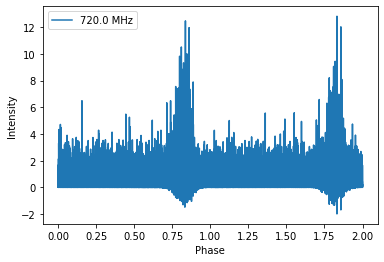

In [14]:
# Get the phases of the pulse
phases = np.linspace(0, obslen/period, len(signal_1.data[0,:]))
# Plot just the pulses in the first frequency channels
plt.plot(phases, signal_1.data[0,:], label = signal_1.dat_freq[0])
plt.ylabel("Intensity")
plt.xlabel("Phase")
plt.legend(loc = 'best')
plt.show()
plt.close()

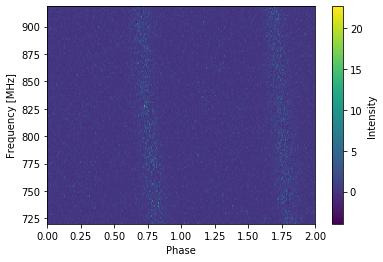

In [15]:
# Make the 2-D plot of intensity v. frequency and pulse phase. You can see the slight dispersive sweep here.
plt.imshow(signal_1.data, aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [min(phases), max(phases), signal_1.dat_freq[0].value, signal_1.dat_freq[-1].value])
plt.ylabel("Frequency [MHz]")
plt.xlabel("Phase")
plt.colorbar(label = "Intensity")
plt.show()
plt.close()